In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import re 
import numpy as np
import os
import pandas as pd
from pyspark.sql import SparkSession
from progressbar import *
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler
from numpy.linalg import eigh
from pyspark.mllib.linalg import *
from pyspark.mllib.stat import Statistics
from scipy.spatial.distance import pdist,squareform
from pyspark.ml.feature import PCA

In [2]:
spark = SparkSession.builder.appName("mnist").getOrCreate()
df = spark.read.json('/project/cmsc25025/mnist/data.json')

In [3]:
subset = df.rdd.map(lambda x: [i for i in x['features']]).take(20)
subset = np.array(subset)
subset[0].shape


(784,)

In [43]:
def plot_numbers(subset, nrows = 4, ncols = 5):

    plt.figure(figsize=(ncols*2, nrows*2))

    for i in xrange(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(subset[i].reshape((28,28)), cmap='gray')
        plt.axis('off'), 

    plt.axis('off')
    plt.show()

### Plot some numbers of the dataset

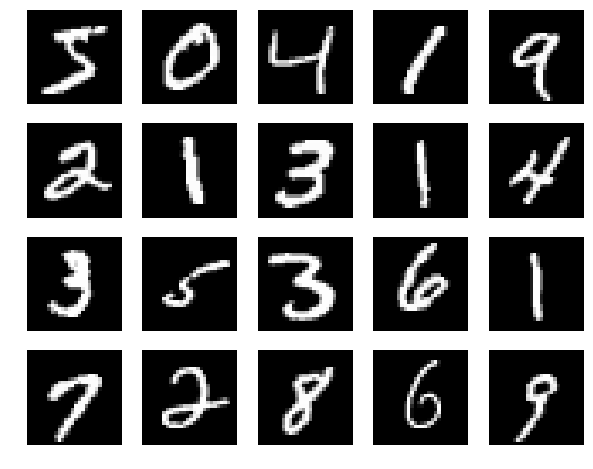

In [21]:
plot_numbers(subset)

In [10]:
# Transform column into a vector column for use with ml library

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

df_vectors = df.select(
    df["label"], df["features"],
    list_to_vector_udf(df["features"]).alias("vectors")
)

In [5]:
df_vectors.printSchema()

root
 |-- label: long (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- vectors: vector (nullable = true)



### Part 1. PCA 

In [3]:
train, test = df.rdd.randomSplit([9, 1], seed= 44)

In [4]:
# First, estimate values

#Estimate the mean
m =  train.map(lambda x: np.array(x['features'])).mean()

#Estimate the standard deviation
sd =  train.map(lambda x: np.array(x['features'])).stdev()

In [5]:
# Then normalize the data

normalize = train.map(lambda x: np.array(x['features'])).map(lambda x: (x - m))

In [6]:
# Calculate variance-covariance 

cov = normalize.map(lambda x: np.outer(x,x)).sum()/df.count()

In [25]:
cov.shape

(784, 784)

In [26]:
cov[0][0]

0.0

In [7]:
def pca(cov, df, k=2):
    """
    Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Args:
        cov: A numpy array with the covariance matrix
        df: A Spark dataframe with a 'features' column, which (column) consists of DenseVectors.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
        scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
        rows equals the length of the arrays in the input `RDD` and the number of columns equals
        `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
        of length `k`.  Eigenvalues is an array of length d (the number of features).
     """
    col = cov.shape[1]
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(eigVals)[::-1]
    topComponents = eigVecs[:,inds[:k]]
    scores = df.rdd.map(lambda x: np.array(x['features'])).map(lambda p: p.dot(topComponents))
    
    return (topComponents, scores , eigVals[inds])

In [11]:
comp, score, eig = pca(cov, df_vectors, 10)

In [12]:
score.take(4)

[array([-3.45441852, -1.29323314,  0.44246219, -4.08503633, -3.45702153,
         0.53817724,  2.87963849,  0.49251932, -0.16908322, -1.1362605 ]),
 array([-6.91036383, -1.17680003,  2.90593117, -3.86887159, -0.3640002 ,
         0.2592324 ,  1.83779478, -0.6767631 , -1.73045674, -0.94602122]),
 array([-2.76573985,  1.46279475,  0.05071693,  0.15581014, -2.3848916 ,
        -0.30281774, -1.41859619,  1.15166426, -1.32688943,  0.42695696]),
 array([ 0.12847451, -2.40733449,  1.84531284, -1.4848094 , -3.76656563,
        -2.98830159,  0.11890397, -0.71602219, -2.7871465 , -0.35749861])]

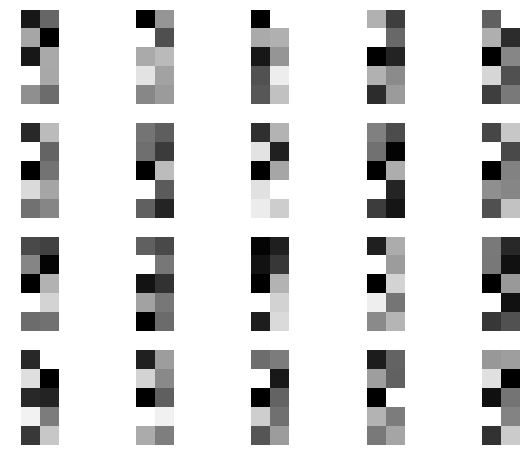

In [13]:
# Graph the PCA with 10 components

subset = score.take(20)

nrows = 4
ncols = 5

plt.figure(figsize=(ncols*2, nrows*2))

for i in xrange(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(subset[i].reshape((5,2)), cmap='gray')
    plt.axis('off')
  
plt.axis('off')
plt.show()


### Check with PCA library

In [31]:
from pyspark.ml.feature import *
from pyspark.mllib.linalg import Vectors

pca = PCA(k=10, inputCol="vectors", outputCol="pca")
model = pca.fit(df_vectors)
transformed = model.transform(df_vectors)


In [32]:
transformed.select(transformed.pca).take(4)

[Row(pca=DenseVector([3.4569, 1.3034, 0.5087, 4.0967, 3.4225, 0.5517, 2.8765, 0.4538, -0.2178, -1.127])),
 Row(pca=DenseVector([6.9266, 1.2008, 2.9589, 3.8162, 0.3277, 0.272, 1.7748, -0.6832, -1.7552, -0.9228])),
 Row(pca=DenseVector([2.7489, -1.4697, 0.0756, -0.146, 2.3914, -0.3313, -1.3997, 1.1782, -1.3127, 0.4209])),
 Row(pca=DenseVector([-0.1338, 2.4409, 1.8628, 1.4951, 3.7149, -3.0223, 0.11, -0.6736, -2.7857, -0.3496]))]

### Plot variance 

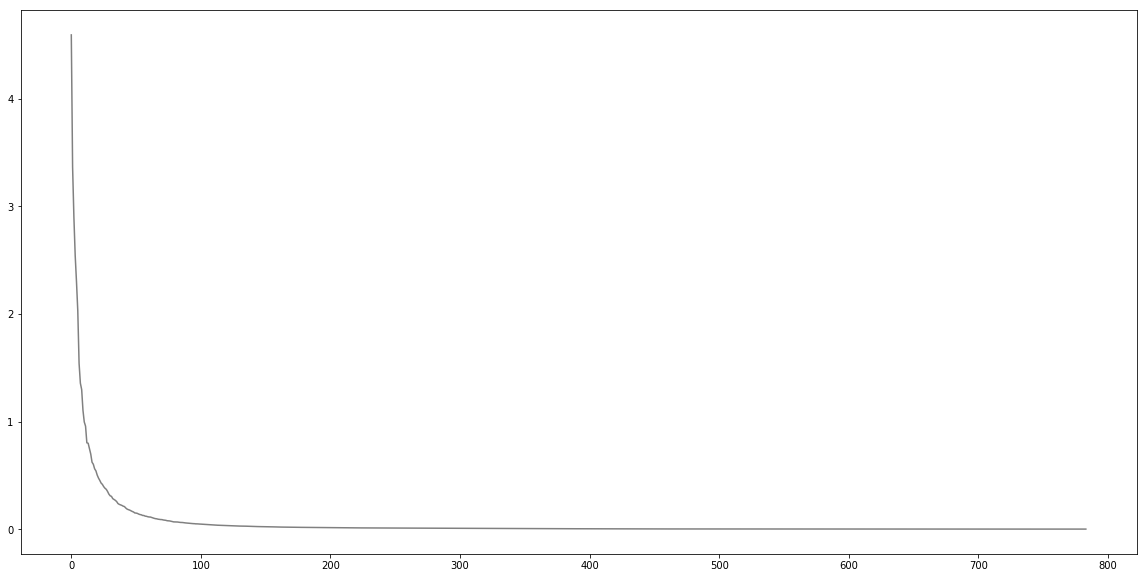

In [14]:
plt.figure
plt.figure(figsize=(20,10))
plt.plot(eig, color = 'grey')
plt.show()

In [15]:
point = np.array(test.map(lambda x: np.array(x['features'])).take(5))

In [16]:
projection = point.dot(comp)

In [17]:
new_point = projection.dot(comp.transpose())

In [18]:
new_point.shape

(5, 784)

### 10 principal components on testing data

As the data is showing, using 10 principal components you start to see some characteristics of models being features as principal componentes, the number 3 for instance has some specific curves that are worth noting. In reality, with 10 components you can pretty much tell what are the numbers from mere eyesight altough they appear blurry

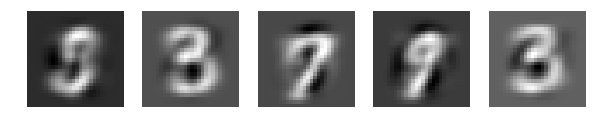

In [73]:
plot_numbers(new_point, nrows = 1, ncols = 5)

### 5 principal components on testing data

As you start to reduce the number of components, the numbers become less clear, but also characteristics such as curves and holes in the three and nine are still evident

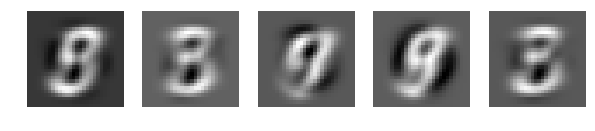

In [82]:
projection = point.dot(comp[:,:5])
new_point = projection.dot(comp[:,:5].transpose())
plot_numbers(new_point, nrows = 1, ncols = 5)

### 3 principal components on testing data

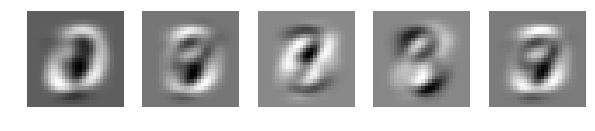

In [83]:
projection = point.dot(comp[:,:3])
new_point = projection.dot(comp[:,:3].transpose())
plot_numbers(new_point, nrows = 1, ncols = 5)

### 2 principal components on testing data

If you narrow it down to one component, it's really hard to see distintions between numbers, altough, still the black spaces in nine are still evident

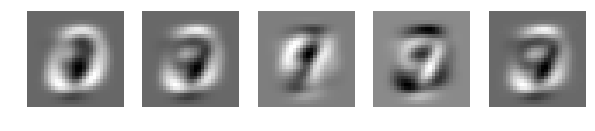

In [84]:
projection = point.dot(comp[:,:2])
new_point = projection.dot(comp[:,:2].transpose())
plot_numbers(new_point, nrows = 1, ncols = 5)

### Error reconstruction

In [20]:
reconstructed_values = test.map(lambda x: np.array(x['features'])).map(lambda point: point.dot(comp))

In [21]:
reconstructed = reconstructed_values.map( lambda projection: projection.dot(comp.transpose())).collect()

In [22]:
reconstructed = np.array(reconstructed)

In [23]:
original = test.map(lambda x: np.array(x['features'])).collect()

In [24]:
error = np.mean(np.mean(np.square(original - reconstructed)))

In [31]:
def reconstruction_error(test, train, comp, i):
    original = test.map(lambda x: np.array(x['features'])).collect()
    reconstructed_values = test.map(lambda x: np.array(x['features'])).map(lambda point: point.dot(comp[:,:i]))
    reconstructed = reconstructed_values.map( lambda projection: projection.dot(comp[:,:i].transpose())).collect()
    reconstructed = np.array(reconstructed)
    error = np.mean(np.mean(np.square(original - reconstructed)))
    
    return error

In [36]:
errors = []
for i in range(1,11):
    errors.append(reconstruction_error(test,train,comp,i))
    

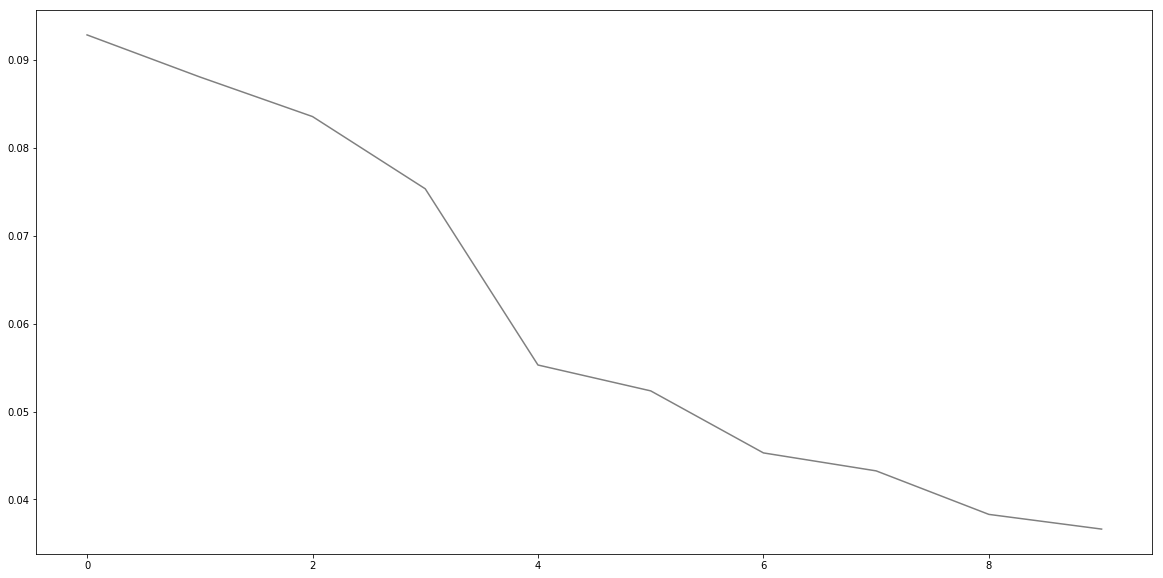

In [37]:
plt.figure
plt.figure(figsize=(20,10))
plt.plot(np.array(errors), color = 'grey')
plt.show()

### Part 2. K-means

In [38]:
from pyspark.mllib.clustering import KMeans

clusters = KMeans.train( df.rdd.map(lambda x: np.array(x['features'])), k = 10, maxIterations =50,
runs=10, initializationMode="random")

/software/spark-2.1-el7-x86_64/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


In [39]:
from pyspark.sql.functions import udf

cluster_udf = udf(lambda x: clusters.predict(x))

df_new = df.select(df["label"], df["features"],
    cluster_udf(df["features"]).alias("clusters"))

In [40]:
counts = df_new.groupBy(['label', 'clusters']).count().alias('counts')
counts.show()

+-----+--------+-----+
|label|clusters|count|
+-----+--------+-----+
|    1|       6| 7721|
|    6|       5| 4917|
|    7|       8| 3250|
|    9|       3|   35|
|    3|       2| 1017|
|    4|       8| 1821|
|    1|       9|    8|
|    1|       0|   55|
|    3|       5|   42|
|    6|       2|   54|
|    9|       0|    5|
|    6|       1|  827|
|    6|       3|   88|
|    7|       2|   10|
|    4|       6|  264|
|    3|       1|  522|
|    0|       9|   67|
|    8|       9|  153|
|    5|       6|  651|
|    8|       0|   50|
+-----+--------+-----+
only showing top 20 rows



In [41]:
import pyspark.sql.functions as F

result = (counts
          .groupBy('clusters')
          .agg(F.max(F.struct(F.col('count'),
                              F.col('label'))).alias('max'))
          .select(F.col('clusters'), F.col('max.label'))
         )
result.show()

+--------+-----+
|clusters|label|
+--------+-----+
|       7|    3|
|       3|    0|
|       8|    7|
|       0|    2|
|       5|    6|
|       6|    1|
|       9|    4|
|       1|    0|
|       4|    9|
|       2|    8|
+--------+-----+



### Plot clusters

When you start checking the clusters, you can quickly see there are some that are respecting the majority label more than others. A really distinctive case is cluster 3 in which all numbers are 0. There are other clusters that are having more difficulties such as 3 or 7.

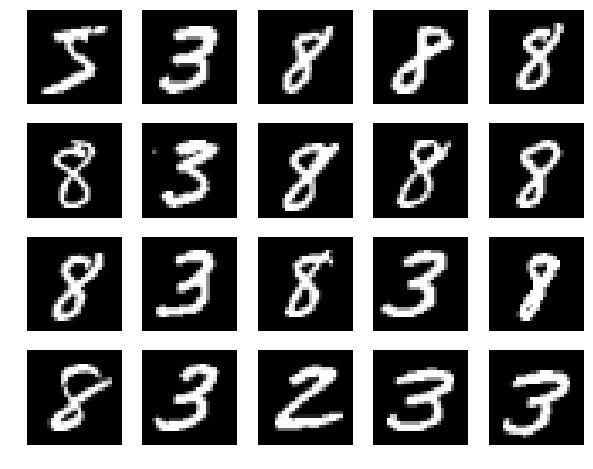

In [44]:
n = 2
cluster_0 = np.array(df_new.rdd.filter(lambda x: x.clusters == str(n)).map(lambda x: [i for i in x['features']]).take(20))
plot_numbers(cluster_0)

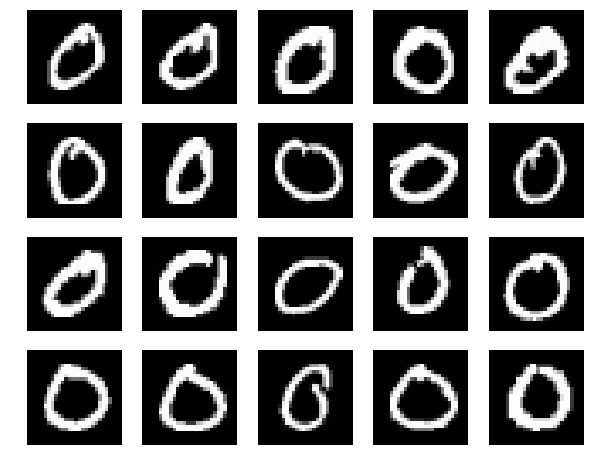

In [45]:
n = 3
cluster_0 = np.array(df_new.rdd.filter(lambda x: x.clusters == str(n)).map(lambda x: [i for i in x['features']]).take(20))
plot_numbers(cluster_0)

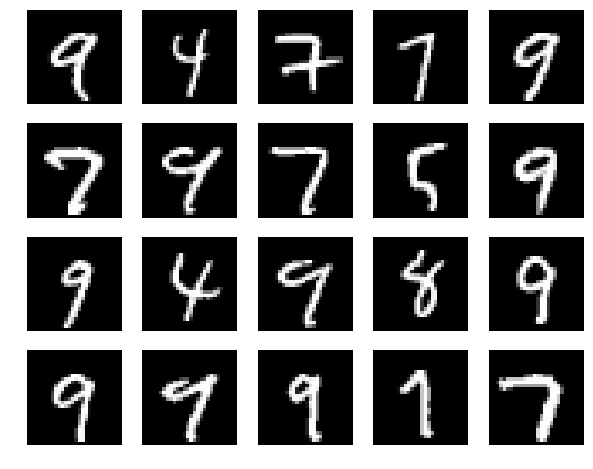

In [46]:
n = 4
cluster_0 = np.array(df_new.rdd.filter(lambda x: x.clusters == str(n)).map(lambda x: [i for i in x['features']]).take(20))
plot_numbers(cluster_0)

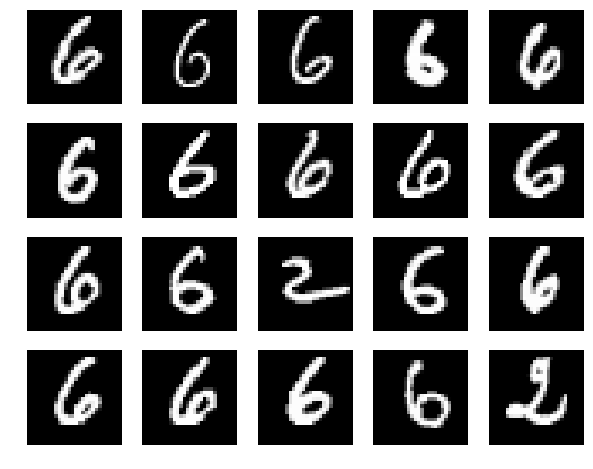

In [47]:
n = 5
cluster_0 = np.array(df_new.rdd.filter(lambda x: x.clusters == str(n)).map(lambda x: [i for i in x['features']]).take(20))
plot_numbers(cluster_0)

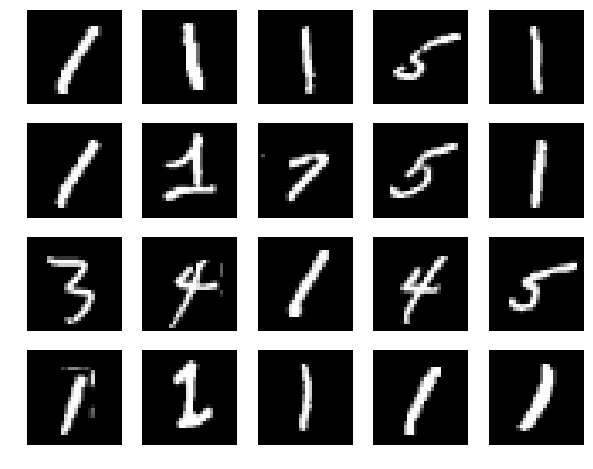

In [48]:
n = 6
cluster_0 = np.array(df_new.rdd.filter(lambda x: x.clusters == str(n)).map(lambda x: [i for i in x['features']]).take(20))
plot_numbers(cluster_0)

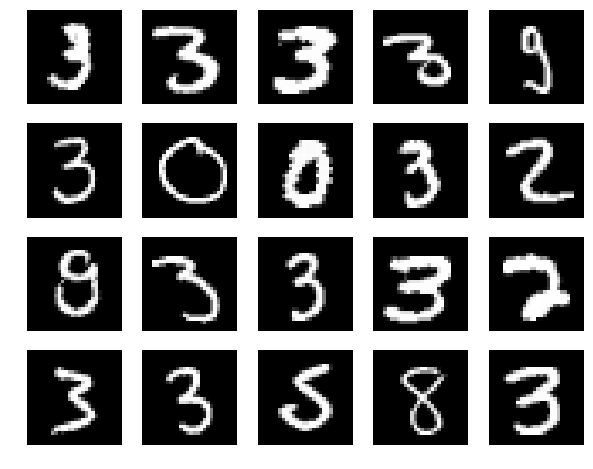

In [49]:
n = 7
cluster_0 = np.array(df_new.rdd.filter(lambda x: x.clusters == str(n)).map(lambda x: [i for i in x['features']]).take(20))
plot_numbers(cluster_0)

### Part 3. Spectral Clustering

In [6]:
from pyspark.ml.feature import PCA
from scipy.spatial import distance
gamma = 1
score = df.rdd.map(lambda x: np.array(x['features'])).map(lambda X: np.exp(-gamma * distance.euclidean(X,X) ** 2))

In [6]:
A = np.array(df.rdd.map(lambda x: np.array(x['features'])).collect())

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/py4j/java_gateway.py", line 883, in send_command
    response = connection.send_command(command)
  File "/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/py4j/java_gateway.py", line 1040, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
Py4JNetworkError: Error while receiving


Py4JError: An error occurred while calling o9.setCallSite

In [ ]:
distance.pdist(A)

### Part 4. Classification 

In [50]:
train, dev, test = df_vectors.rdd.randomSplit([4, 1, 1], seed= 43)

In [51]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint 
labeled = train.map(lambda x : LabeledPoint(x["label"],x["features"]))
model = LogisticRegressionWithLBFGS.train(labeled, iterations = 10, numClasses = 10)

In [52]:
predictionAndLabels = dev.map(lambda x: (float(model.predict(x.features)), float(x.label)))

In [53]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(predictionAndLabels)


In [54]:
# Area under precision-recall curve
# https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html
print("Area under PR = %s" % metrics.areaUnderPR)


Area under PR = 0.990568424368


In [55]:
from pyspark.mllib.evaluation import RegressionMetrics
metrics_1 = RegressionMetrics(predictionAndLabels)

metrics_1.meanSquaredError

2.2092863284608772

In [56]:
df_vectors.printSchema()

root
 |-- label: long (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- vectors: vector (nullable = true)



In [57]:
# Now we use PCA 
pca = PCA(k=2, inputCol="vectors", outputCol="pca_2")
model = pca.fit(df_vectors)

In [58]:
transformed = model.transform(df_vectors)

In [59]:
transformed.printSchema()

root
 |-- label: long (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- vectors: vector (nullable = true)
 |-- pca_2: vector (nullable = true)



In [60]:
train, dev, test = transformed.rdd.randomSplit([4, 1, 1], seed= 43)

In [61]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint 

labeled = train.map(lambda x : LabeledPoint(x["label"],np.array(x["pca_2"])))
model = LogisticRegressionWithLBFGS.train(labeled, iterations = 10, numClasses = 10)
predictionAndLabels = dev.map(lambda x: (float(model.predict(np.array(x.pca_2))), float(x.label)))


In [62]:
from pyspark.mllib.evaluation import RegressionMetrics

metrics = RegressionMetrics(predictionAndLabels)
metrics.meanSquaredError

11.58701633705933

In [63]:
results = [[2, metrics.meanSquaredError]]
#We loop for from 3 to 10 components 
for i in range(3,11):
    print(i)
    pca = PCA(k=i, inputCol="vectors", outputCol="pca_" + str(i))
    model = pca.fit(df_vectors)
    transformed = model.transform(df_vectors)
    train, dev, test = transformed.rdd.randomSplit([4, 1, 1], seed= 43)
    labeled = train.map(lambda x : LabeledPoint(x["label"],np.array(x["pca_" + str(i)])))
    model = LogisticRegressionWithLBFGS.train(labeled, iterations = 10, numClasses = 10)
    predictionAndLabels = dev.map(lambda x: (float(model.predict(np.array(x["pca_" + str(i)]))), float(x.label)))
    metrics = RegressionMetrics(predictionAndLabels)
    results.append([i,metrics.meanSquaredError])
    
    

3
4
5
6
7
8
9
10


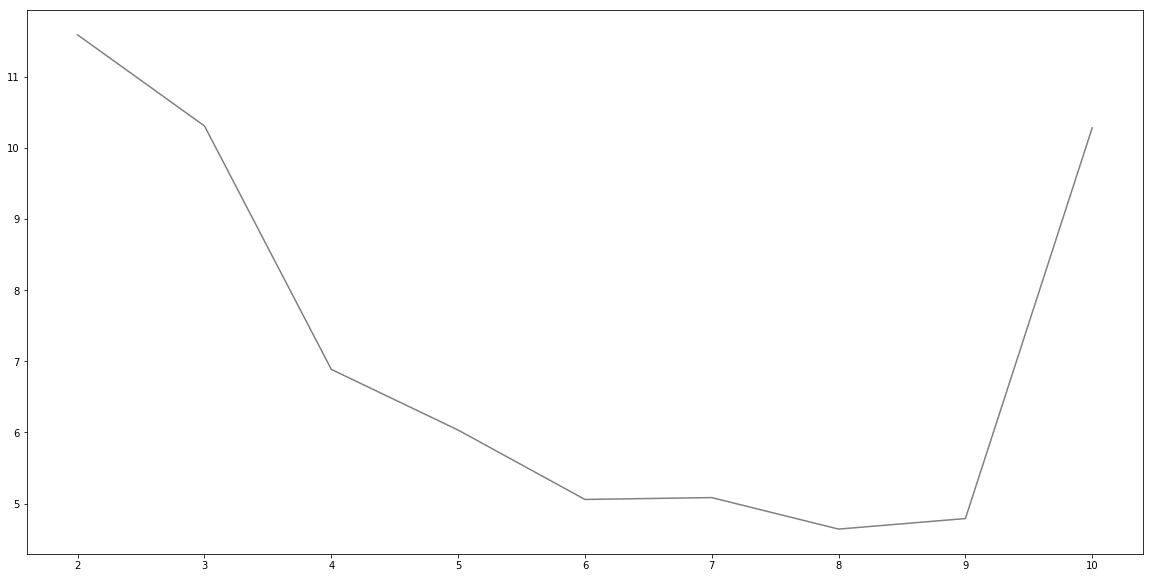

In [64]:
result_array = np.array(results)
plt.figure(figsize=(20,10))
plt.plot(result_array[:,0], result_array[:,1], color = 'grey')
plt.show()

In [65]:
#The component that minimizes the error is 8 
results_comparison = []
pca = PCA(k=8, inputCol="vectors", outputCol="pca")
model = pca.fit(df_vectors)
transformed = model.transform(df_vectors)
train, dev, test = transformed.rdd.randomSplit([4, 1, 1], seed= 43)
new_train = train + dev

labeled_PCA = new_train.map(lambda x : LabeledPoint(x["label"],np.array(x["pca" ])))
model = LogisticRegressionWithLBFGS.train(labeled_PCA, iterations = 10, numClasses = 10)
predictionAndLabels = test.map(lambda x: (float(model.predict(np.array(x["pca"]))), float(x.label)))
metrics = RegressionMetrics(predictionAndLabels)
results_comparison.append(["PCA",metrics.meanSquaredError])

labeled_OLS = new_train.map(lambda x : LabeledPoint(x["label"],x["features"]))
model = LogisticRegressionWithLBFGS.train(labeled_OLS, iterations = 10, numClasses = 10)
predictionAndLabels = test.map(lambda x: (float(model.predict(x.features)), float(x.label)))
metrics = RegressionMetrics(predictionAndLabels)
results_comparison.append(["OLS",metrics.meanSquaredError])


In [66]:
results_comparison

[['PCA', 4.524525722098787], ['OLS', 2.1731327978123396]]

As the data is showing, using PCA does not minimize the error with respect to using the features in logistic regression. In this case, there is a significant difference between both of almost twice the error rate. 